In [42]:
include("../VidalTEBD.jl")
using .VidalTEBD
using Plots
using LinearAlgebra
pyplot()

Plots.PyPlotBackend()

prepare the initial state used by Gil Rafael

In [3]:
PS = zeros(Complex{Float64},2,N)
down_site = [im*0.9, 1]/sqrt(0.9^2 + 1)
up_site = [im*1.1, 1]/sqrt(1.1^2 + 1)
for i in 1:N
    if i%8 in [1,2,7,0]
        PS[:,i] = down_site
    elseif i%8 in [3,4,5,6]
        PS[:,i] = up_site
    end
end

In [43]:
function make_TFIM_H(hx,hz,N)
    OneSite = zeros(Float64,4,N)
    OneSite[2,:] = hx/2 .* ones(Float64,N)
    OneSite[4,:] = hz/2 .* ones(Float64,N) #h_i at each site
    TwoSite = zeros(Float64,3,3,N)
    TwoSite[3,3,1:N-1] = ones(Float64,N-1) #SzSz
    H = VidalTEBD.NNSpinHalfHamiltonian(OneSite,TwoSite)
    VidalTEBD.makeNNQuadH(H)
end

function makeMPOforTHIM(hx,hz,N)
    d = 2
    M1 = [1,0,0]
    Mend = [0,0,1]
    M = zeros(Complex{Float64},3,3,d,d)
    M[1,1,:,:] = Matrix{Complex{Float64}}(I,d,d)
    M[1,2,:,:] = [1/2 0;0 -1/2]
    M[1,3,:,:] = hx/2*[0 1/2;1/2 0]+hz/2*[1/2 0;0 -1/2]
    M[2,3,:,:] = [1/2 0;0 -1/2]
    M[3,3,:,:] = Matrix{Complex{Float64}}(I,d,d)
    Mall = zeros(Complex{Float64},3,3,d,d,N)
    for i in 1:N
        Mall[:,:,:,:,i] = M
    end
    VidalTEBD.MatrixProductOperator(M1,Mall,Mend)
end

makeMPOforTHIM (generic function with 1 method)

## comparing different TEBD methods

In [48]:
#initialization
N = 32
t = 24pi
J = 1
hx = 0.9045
hz = 0.8090
Nt = 200
D = 16

H = make_TFIM_H(hx,hz,N)
MPO = makeMPOforTHIM(hx,hz,N)

MPS = VidalTEBD.make_productVidalMPS(PS,D)
@time result_TEBD = VidalTEBD.TEBD!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)
MPS = VidalTEBD.make_productVidalMPS(PS,D)
@time result_traverse = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)
MPS = VidalTEBD.make_productVidalMPS(PS,D)
@time result_stoc = VidalTEBD.stochasticTEBD!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)
MPS = VidalTEBD.make_productVidalMPS(PS,D)
@time result_stoc_trav = VidalTEBD.stochasticTEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)

  8.018661 seconds (2.82 M allocations: 2.697 GiB, 8.84% gc time)
 13.878353 seconds (4.27 M allocations: 4.383 GiB, 7.44% gc time)
 11.002149 seconds (3.33 M allocations: 2.762 GiB, 8.91% gc time)
 15.090393 seconds (5.31 M allocations: 4.513 GiB, 8.48% gc time)


Dict{Any,Any} with 2 entries:
  "MPOvalue"   => Complex{Float64}[0.0052438+5.55112e-17im, 0.00509503+2.27899e…
  "renyivalue" => [-0.0, 0.0163432, 0.0587468, 0.112764, 0.161976, 0.194199, 0.…

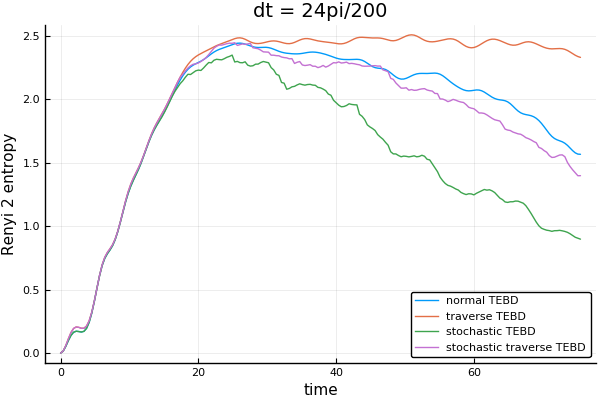

In [45]:
Nt = 200
timetrace = (0:Nt)*t/Nt
plot(timetrace,result_TEBD["renyivalue"],label = "normal TEBD")
plot!(timetrace,result_traverse["renyivalue"],label = "traverse TEBD")
plot!(timetrace,result_stoc["renyivalue"], label = "stochastic TEBD")
plot!(timetrace,result_stoc_trav["renyivalue"], label = "stochastic traverse TEBD")
title!("dt = 24pi/200")
xlabel!("time")
ylabel!("Renyi 2 entropy")

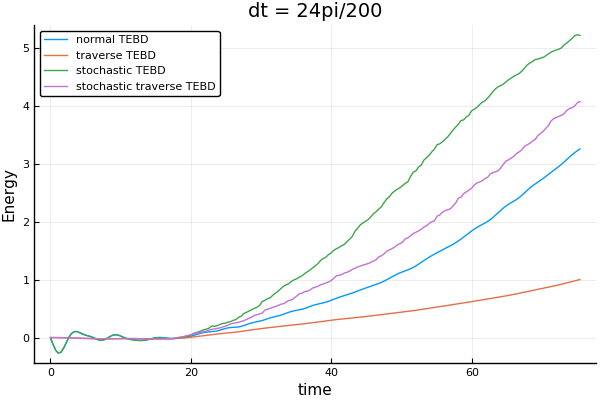

In [47]:
Nt = 200
timetrace = (0:Nt)*t/Nt
plot(timetrace,real(result_TEBD["MPOvalue"]),label = "normal TEBD")
plot!(timetrace,real(result_traverse["MPOvalue"]),label = "traverse TEBD")
plot!(timetrace,real(result_stoc["MPOvalue"]), label = "stochastic TEBD")
plot!(timetrace,real(result_stoc_trav["MPOvalue"]), label = "stochastic traverse TEBD")
title!("dt = 24pi/200")
xlabel!("time")
ylabel!("Energy")

## testing TEBD_traverse more

### time step dependence

In [57]:
#initialization
N = 32
t = 24pi
J = 1
hx = 0.9045
hz = 0.8090
D = 16

H = make_TFIM_H(hx,hz,N)
MPO = makeMPOforTHIM(hx,hz,N)


MPS = VidalTEBD.make_productVidalMPS(PS,D)
Nt = 200
@time result_traverse_1 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)
MPS = VidalTEBD.make_productVidalMPS(PS,D)
Nt= 100
@time result_traverse_2 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)
MPS = VidalTEBD.make_productVidalMPS(PS,D)
Nt = 400
@time result_traverse_3 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)
MPS = VidalTEBD.make_productVidalMPS(PS,D)
Nt = 800
@time result_traverse_4 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)

 14.696756 seconds (4.27 M allocations: 4.383 GiB, 7.94% gc time)
  7.204339 seconds (2.14 M allocations: 2.194 GiB, 7.99% gc time)
 29.829271 seconds (8.53 M allocations: 8.760 GiB, 7.83% gc time)
 57.710429 seconds (17.06 M allocations: 17.515 GiB, 7.71% gc time)


Dict{Any,Any} with 2 entries:
  "MPOvalue"   => Complex{Float64}[0.0052438+5.55112e-17im, 0.00524296+4.22839e…
  "renyivalue" => [-0.0, 0.00107458, 0.00424161, 0.00939048, 0.0163779, 0.02503…

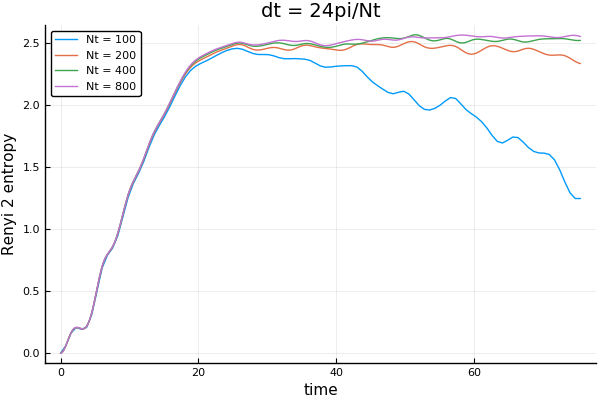

In [54]:
timetrace_1 = (0:200)*t/200
timetrace_2 = (0:100)*t/100
timetrace_3 = (0:400)*t/400
timetrace_4 = (0:800)*t/800
plot(timetrace_2,result_traverse_2["renyivalue"],label = "Nt = 100")
plot!(timetrace_1,result_traverse_1["renyivalue"],label = "Nt = 200")
plot!(timetrace_3,result_traverse_3["renyivalue"],label = "Nt = 400")
plot!(timetrace_4,result_traverse_4["renyivalue"],label = "Nt = 800")
title!("dt = 24pi/Nt")
xlabel!("time")
ylabel!("Renyi 2 entropy")

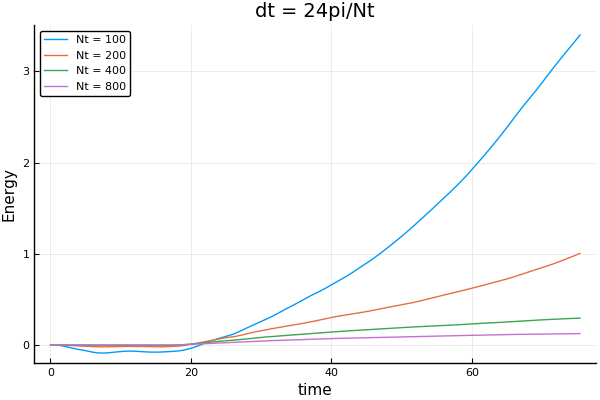

In [56]:
timetrace_1 = (0:200)*t/200
timetrace_2 = (0:100)*t/100
timetrace_3 = (0:400)*t/400
timetrace_4 = (0:800)*t/800
plot(timetrace_2,real(result_traverse_2["MPOvalue"]),label = "Nt = 100")
plot!(timetrace_1,real(result_traverse_1["MPOvalue"]),label = "Nt = 200")
plot!(timetrace_3,real(result_traverse_3["MPOvalue"]),label = "Nt = 400")
plot!(timetrace_4,real(result_traverse_4["MPOvalue"]),label = "Nt = 800")
title!("dt = 24pi/Nt")
xlabel!("time")
ylabel!("Energy")

### bond dimension dependence

In [60]:
#initialization
N = 32
t = 24pi
J = 1
hx = 0.9045
hz = 0.8090
D = 16
Nt = 400

H = make_TFIM_H(hx,hz,N)
MPO = makeMPOforTHIM(hx,hz,N)

D = 16
MPS = VidalTEBD.make_productVidalMPS(PS,D)
@time result_traverse_D16 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)
D= 8
MPS = VidalTEBD.make_productVidalMPS(PS,D)
@time result_traverse_D8 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)
D = 32
MPS = VidalTEBD.make_productVidalMPS(PS,D)
@time result_traverse_D32 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)
D = 64
MPS = VidalTEBD.make_productVidalMPS(PS,D)
@time result_traverse_D64 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 16,MPO=MPO)

 36.473299 seconds (8.53 M allocations: 8.760 GiB, 6.76% gc time)
 13.135993 seconds (8.46 M allocations: 2.810 GiB, 7.04% gc time)
127.761753 seconds (9.04 M allocations: 31.674 GiB, 5.92% gc time)
675.335377 seconds (9.19 M allocations: 121.581 GiB, 2.21% gc time)


Dict{Any,Any} with 2 entries:
  "MPOvalue"   => Complex{Float64}[0.0052438+5.55112e-17im, 0.00523264-1.2631e-…
  "renyivalue" => [-0.0, 0.00423971, 0.0163709, 0.0351326, 0.0588303, 0.0854623…

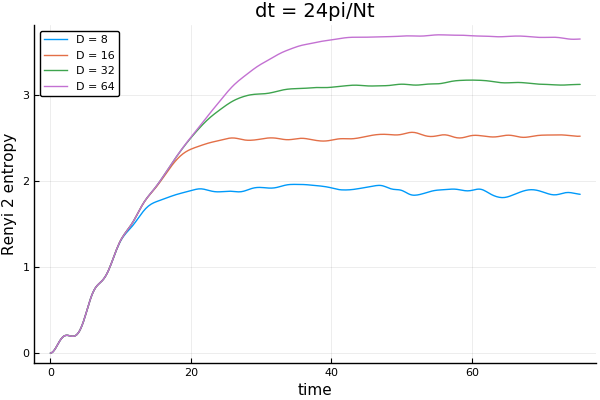

In [61]:
timetrace = (0:400)*t/400
plot(timetrace,result_traverse_D8["renyivalue"],label = "D = 8")
plot!(timetrace,result_traverse_D16["renyivalue"],label = "D = 16")
plot!(timetrace,result_traverse_D32["renyivalue"],label = "D = 32")
plot!(timetrace,result_traverse_D64["renyivalue"],label = "D = 64")
title!("dt = 24pi/Nt")
xlabel!("time")
ylabel!("Renyi 2 entropy")

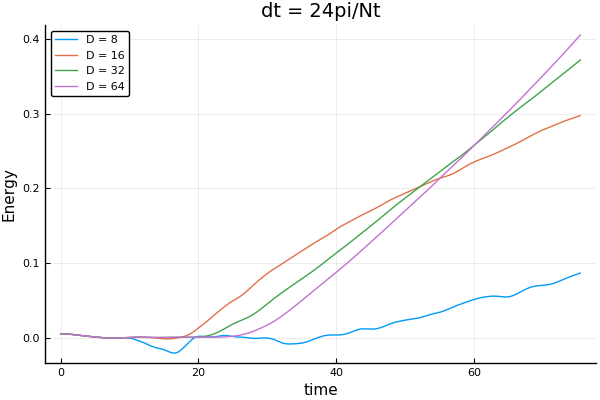

In [62]:
timetrace = (0:400)*t/400
plot(timetrace,real(result_traverse_D8["MPOvalue"]),label = "D = 8")
plot!(timetrace,real(result_traverse_D16["MPOvalue"]),label = "D = 16")
plot!(timetrace,real(result_traverse_D32["MPOvalue"]),label = "D = 32")
plot!(timetrace,real(result_traverse_D64["MPOvalue"]),label = "D = 64")
title!("dt = 24pi/Nt")
xlabel!("time")
ylabel!("Energy")

## Reproducing the plot from Gil Refael's paper

In [ ]:
#initialization
N = 64
t = 80pi
J = 1
hx = 0.9045
hz = 0.8090
D = 64

PS2 = zeros(Complex{Float64},2,N)
down_site = [im*0.9, 1]/sqrt(0.9^2 + 1)
up_site = [im*1.1, 1]/sqrt(1.1^2 + 1)
for i in 1:N
    if i%8 in [1,2,7,0]
        PS2[:,i] = down_site
    elseif i%8 in [3,4,5,6]
        PS2[:,i] = up_site
    end
end

H = make_TFIM_H(hx,hz,N)
MPO = makeMPOforTHIM(hx,hz,N)


MPS = VidalTEBD.make_productVidalMPS(PS2,D)
Nt = 400
@time result_traverse_Nt400 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 32,MPO=MPO)
MPS = VidalTEBD.make_productVidalMPS(PS2,D)
Nt= 800
@time result_traverse_Nt800 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 32,MPO=MPO)
MPS = VidalTEBD.make_productVidalMPS(PS2,D)
Nt = 2000
@time result_traverse_Nt2000 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 32,MPO=MPO)
MPS = VidalTEBD.make_productVidalMPS(PS2,D)
Nt = 4000
@time result_traverse_Nt4000 = VidalTEBD.TEBD_traverse!(MPS,H,t,Nt,α=2,loc = 32,MPO=MPO)

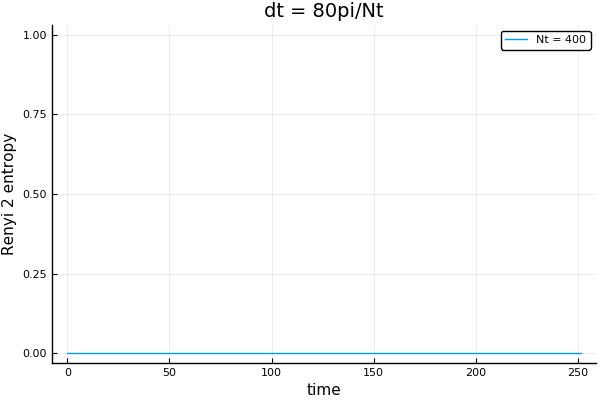

In [71]:
timetrace_1 = (0:400)*t/400
timetrace_2 = (0:800)*t/800
timetrace_3 = (0:2000)*t/2000
timetrace_4 = (0:4000)*t/4000

plot(timetrace_1,result_traverse_Nt400["renyivalue"],label = "Nt = 400")
plot!(timetrace_2,result_traverse_Nt800["renyivalue"],label = "Nt = 800")
plot!(timetrace_3,result_traverse_Nt2000["renyivalue"],label = "Nt = 2000")
plot!(timetrace_4,result_traverse_Nt4000["renyivalue"],label = "Nt = 4000")
title!("dt = 80pi/Nt")
xlabel!("time")
ylabel!("Renyi 2 entropy")